# N-armed Bandits

## Epsilon-greedy strategy

Given 10 slot machines with differing probabilities of paying out, find a strategy to maximize getting paid. Each arm has a random probability of paying out, and we are trying to determine which has the highest probability.

Most of the time choose the arm with the best known probability of paying out(exploitation), but occasionally (choosing from a random probability epsilon) pick a random arm to try to learn more about the environment and potentially find a better arm (exploration).

In [1]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

n = 10 # number of arms
probs = np.random.rand(n) # hidden probabilities associated with each arm
eps = 0.2 # epsilon for the epsilon-greedy action selection

In [2]:
def get_reward(prob, n=10):
    reward = 0
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

Given a single arm with a 70% probability of paying out a reward of 1 and running 10 iterations (so a max reward of 10), we see that the longer we run the closer we get to a mean reward of 7 for the arm.

In [3]:
reward_test = [get_reward(0.7, n=10) for _ in range(2000)]
np.mean(reward_test)

7.0335

(array([  1.,   3.,  22.,  73., 209., 383., 500., 489., 320.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 9 Patch objects>)

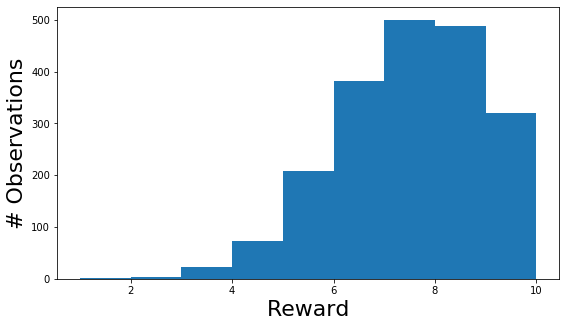

In [4]:
plt.figure(figsize=(9,5))
plt.xlabel("Reward",fontsize=22)
plt.ylabel("# Observations",fontsize=22)
plt.hist(reward_test,bins=9)

In [5]:
# 10 actions x 2 columns
# Columns: Count #, Avg Reward
records = np.zeros((n, 2))
records

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [6]:
# Takes the records array, an action (index value of the arm), and a new reward observation
# Then updates the average reward for the arm
def update_records(records, action, r):
    new_r = (records[action, 0] * records[action, 1] + r) / (records[action, 0] + 1)
    records[action, 0] += 1
    records[action, 1] = new_r
    return records

In [7]:
# Given our array of records, find the arm with the highest probability of payout
def get_best_arm(records):
    arm_index = np.argmax(records[:, 1], axis=0)
    return arm_index

Highest probability: 0.9518422506414441


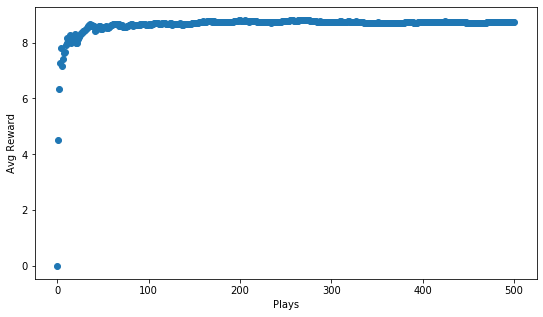

In [8]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)

records = np.zeros((n, 2))

num_arms = 10
probs = np.random.rand(num_arms)  # hidden probabilities associated with each arm
eps = 0.2 # epsilon for the epsilon-greedy action selection

rewards = [0]
for i in range(500):
    if random.random() > eps:
        choice = get_best_arm(records)
    else:
        choice = np.random.randint(num_arms)
    r = get_reward(probs[choice])
    records = update_records(records,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)),rewards)

print('Highest probability: ' + str(np.amax(probs)))

## Softmax selection policy

Softmax gives us a probability distribution over our options, with the largest probability being the best arm. This allows us to explore, but with a lower likelihood of picking a poorly performing arm.

For this problem softmax tends to converge on an optimal policy faster than epsilon greedy, but is very sensitive to the tau value and can take some time to find a good value (whereas finding an epsion parameter tends to be more intuitive).

In [9]:
def softmax(av, tau=1.12):
    softm = np.exp(av / tau) / np.sum(np.exp(av / tau))
    return softm

Highest probability: 0.8402165336734575


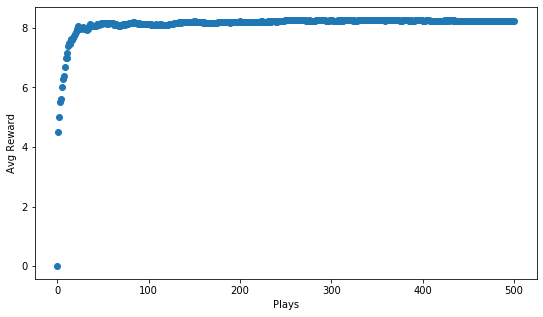

In [10]:
n = 10
probs = np.random.rand(n)
records = np.zeros((n,2))

fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
rewards = [0]
for i in range(500):
    p = softmax(records[:,1],tau=0.7)
    choice = np.random.choice(np.arange(n),p=p)
    r = get_reward(probs[choice])
    records = update_records(records,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)),rewards)

print('Highest probability: ' + str(np.amax(probs)))

## Contextual Bandits

In [11]:
import numpy as np
import torch

In [12]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        # each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [13]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

In [14]:
arms = 10
loss_fn = torch.nn.MSELoss()
env = ContextBandit(arms)

N = 1
D_in = arms
H = 100
D_out = arms

In [15]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

In [16]:
def train(env, epochs=5000, learning_rate=1e-2):
    # Convert the environment's current state to a PyTorch variable
    cur_state = torch.Tensor(one_hot(arms,env.get_state()))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for i in range(epochs):
        y_pred = model(cur_state)
        
        # Convert reward predictions to probability distribution with softmax
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0)
        
        # Normalize distribution to ensure it sums to 1
        av_softmax /= av_softmax.sum()
        
        # Choose new action probabilistically
        choice = np.random.choice(arms, p=av_softmax)
        
        # Take action, recieve reward
        cur_reward = env.choose_arm(choice)
        
        # Convert PyTorch data to a numpy array
        one_hot_reward = y_pred.data.numpy().copy()
        
        # Update one_hot_reward array to use as labeled training data
        one_hot_reward[choice] = cur_reward
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update current environment state
        cur_state = torch.Tensor(one_hot(arms,env.get_state()))
    return np.array(rewards)

In [17]:
rewards = train(env)

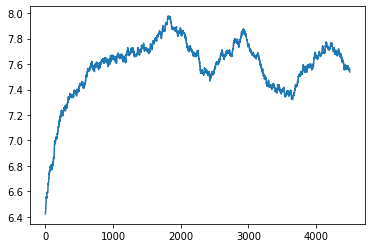

In [18]:
plt.plot(running_mean(rewards,N=500))